# Fine-tuning an Image Model

This notebook is part of [Lab 2](https://github.com/ee292d/labs/blob/main/lab2/README.md) for the [EE292D Edge ML class](https://ee292d.github.io/) at Stanford. It shows how to prepare an image classification model for your Pi, and fine-tune it to recognize different kinds of objects. It should take around 30 minutes to complete.

If you're not already in Google's Colab environment (or another notebook client) [click here to open it in Colab](https://colab.research.google.com/github/ee292d/labs/blob/main/lab2/notebook.ipynb).

## Pick a GPU Instance

If you're running on Google's Colab service (which I recommend as a great environment) then by default you'll probably be on a server without a GPU. This notebook will still work, but the training section will take longer, and GPUs are available for no charge, so it's worth upgrading. To do this click on the connection dropdown on the top left:

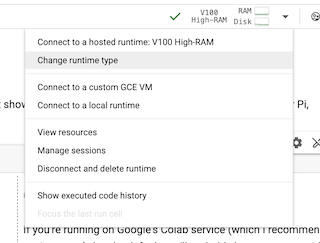

Then choose a v100 GPU from the dialog (any GPU will do, if these options changes in the future):

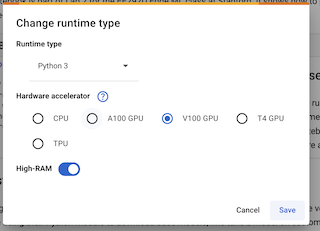

Now connect or reconnect to the instance to make sure you have access to a GPU.

## Install Ultralytics

I'm a big fan of the [Ultralytics project](https://github.com/ultralytics/ultralytics) that provides a free, open source wrapper for some very efficient image models from the YOLO family. We'll be using their Python module to download base models, fine tune a model on custom data, and export the result to TensorFlow Lite to run on the Raspberry Pi.

When you run this snippet you should see a lot of log messages about installation, followed by a "Setup complete" message. If the GPU selection in the previous step worked, you'll see something like `CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)` on the first line, indicating you have an instance with a GPU. It should take a couple of minutes to complete.

In [4]:
%pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 29.3/201.2 GB disk)


## Download and Run an Image Classifier Model

Ultralytics is based around the YOLO family of image models. These are designed to be efficient, come in a range of sizes, and offer [different kinds of prediction](https://docs.ultralytics.com/tasks/). To get started we'll be using version 8 of the classification model (indicated by the `cls` suffix) in the nano size (the `n` suffix), which is trained on the ImageNet dataset.

In these two lines we'll download and create the model, and then run it on a test image. This is a picture of Admiral Grace Hopper, and since there are no person labels in ImageNet we expect to see `military_uniform` as the top label.

In [5]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")
_ = model("https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")

100%|██████████| 5.30M/5.30M [00:00<00:00, 158MB/s]


100%|██████████| 59.9k/59.9k [00:00<00:00, 1.95MB/s]


image 1/1 /content/grace_hopper.jpg: 224x224 military_uniform 0.86, bolo_tie 0.05, bow_tie 0.03, suit 0.01, jersey 0.01, 3.5ms
Speed: 67.4ms preprocess, 3.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


## Create your Dataset

To run image classification on your own problem you'll need to train a custom model. One of the easiest ways to do this is transfer learning, where you take a model trained on a large dataset like Imagenet, freeze all the weights but the last layer, and then train on a smaller dataset of your own. This tends to be faster than full retraining, and produces higher accuracy for small datasets.

In this example I'll be using a dataset of five types of flowers (daisies, dandelions, roses, sunflowers, and tulips) that I created years ago for TensorFlow. Ultralytics expects its image datasets to be arranged slightly differently than this one, with `train` and `test` folders at the root, each containing folders named after the image labels. The lines below shuffle around the image files to match that hierarchy. Here's a diagram:

```bash
train/
  daisy/
    5547758_eea9edfd54_n.jpg
    ...
  dandelion/
    ...
  rose/
    ...
  sunflower/
    ...
  tulip/
    ...
test/
  daisy/
    ...
  dandelion/
    ...
  rose/
    ...
  sunflower/
    ...
  tulip/
    ...

```

When you set out to train your own model, you'll need to create your own dataset laid out in the same way.

In [1]:
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
!tar xzf flower_photos.tgz
!mkdir flower_photos/train
!mkdir flower_photos/test
!mv flower_photos/daisy flower_photos/train
!mv flower_photos/dandelion flower_photos/train
!mv flower_photos/roses flower_photos/train
!mv flower_photos/sunflowers flower_photos/train
!mv flower_photos/tulips flower_photos/train

!mkdir flower_photos/test/daisy
!mkdir flower_photos/test/dandelion
!mkdir flower_photos/test/roses
!mkdir flower_photos/test/sunflowers
!mkdir flower_photos/test/tulips

!mv flower_photos/train/daisy/9*.jpg flower_photos/test/daisy/
!mv flower_photos/train/dandelion/9*.jpg flower_photos/test/dandelion/
!mv flower_photos/train/roses/9*.jpg flower_photos/test/roses/
!mv flower_photos/train/sunflowers/9*.jpg flower_photos/test/sunflowers/
!mv flower_photos/train/tulips/9*.jpg flower_photos/test/tulips/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  36.8M      0  0:00:05  0:00:05 --:--:-- 42.2M


## Train your Model

Now we'll run training on this dataset. Here are the arguments we'll pass in:

`data`: The path to our uncompressed dataset.

`epochs`: How many times to run through the dataset during training. Raising this might raise the accuracy, but it will take longer to complete. 50 seems reasonable for this dataset.

`freeze`: How many layers to freeze. This model has ten layers total, so this indicates that all but the last should have their weights untouched. You can omit this if you want to do full model training, but overall accuracy may suffer if your dataset is too small.

With the default settings on a GPU instance the training process should take about five minutes to complete.

In [6]:
results = model.train(data="flower_photos", epochs=50, freeze=9)
save_dir = results.save_dir

Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=flower_photos, epochs=50, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=9, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 6.23M/6.23M [00:00<00:00, 186MB/s]


AMP: checks passed ✅


train: Scanning /content/flower_photos/train... 3511 images, 0 corrupt: 100%|██████████| 3511/3511 [00:01<00:00, 2683.17it/s]


train: New cache created: /content/flower_photos/train.cache


val: Scanning /content/flower_photos/test... 159 images, 0 corrupt: 100%|██████████| 159/159 [00:00<00:00, 2081.81it/s]

val: New cache created: /content/flower_photos/test.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/train
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/50      0.35G      1.616         16        224:  14%|█▍        | 31/220 [00:01<00:06, 28.46it/s]

       1/50      0.35G      1.598         16        224:  29%|██▊       | 63/220 [00:02<00:05, 31.02it/s]
100%|██████████| 755k/755k [00:00<00:00, 36.6MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 18.32it/s]

                   all      0.642          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]

                   all      0.742          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 52.42it/s]

                   all      0.698          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 65.10it/s]

                   all      0.742          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]

                   all      0.792          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 36.75it/s]

                   all      0.786          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]

                   all      0.774          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


                   all      0.774          1

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 51.80it/s]


                   all      0.786          1

      Epoch    GPU_mem       loss  Instances       Size


      10/50     0.352G     0.8243          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


                   all      0.805          1

      Epoch    GPU_mem       loss  Instances       Size


      11/50     0.352G     0.8282          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 46.70it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50     0.352G     0.7982          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 60.42it/s]

                   all      0.792          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50     0.352G     0.8078          7        224: 100%|██████████| 220/220 [00:06<00:00, 35.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 45.64it/s]

                   all      0.818          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50     0.352G     0.8056          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 58.06it/s]


                   all      0.843          1

      Epoch    GPU_mem       loss  Instances       Size


      15/50     0.352G     0.7971          7        224: 100%|██████████| 220/220 [00:06<00:00, 35.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 41.06it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50     0.352G     0.7874          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 63.17it/s]

                   all      0.799          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50     0.352G     0.7787          7        224: 100%|██████████| 220/220 [00:06<00:00, 35.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 47.30it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50     0.352G     0.7681          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 73.93it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50     0.352G     0.7615          7        224: 100%|██████████| 220/220 [00:06<00:00, 35.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 57.72it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50     0.354G     0.7795          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 54.23it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50     0.352G     0.7567          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 37.72it/s]

                   all      0.792          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50     0.352G     0.7516          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 60.64it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50     0.352G     0.7412          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 53.03it/s]

                   all      0.792          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50     0.352G     0.7395          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 59.98it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50     0.352G     0.7641          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 46.97it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50     0.352G     0.7363          7        224: 100%|██████████| 220/220 [00:06<00:00, 34.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 60.37it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50     0.352G     0.7609          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 52.10it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50     0.352G     0.7418          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 66.92it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50     0.352G     0.7392          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50     0.352G     0.7433          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 63.81it/s]

                   all      0.818          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50     0.352G     0.7496          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 56.57it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50     0.352G     0.7238          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 66.29it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50     0.352G     0.7345          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 45.19it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50     0.352G     0.7181          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 55.87it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50     0.352G     0.7074          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 82.97it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50     0.352G     0.7239          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 34.72it/s]

                   all      0.843          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50     0.352G     0.7298          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 54.06it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50     0.352G      0.727          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 57.75it/s]


                   all      0.855          1

      Epoch    GPU_mem       loss  Instances       Size


      39/50     0.352G     0.7129          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 39.22it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50     0.352G     0.7121          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 64.13it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50     0.352G     0.7141          7        224: 100%|██████████| 220/220 [00:06<00:00, 31.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 37.88it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50     0.352G      0.712          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 39.92it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50     0.352G     0.7205          7        224: 100%|██████████| 220/220 [00:06<00:00, 34.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 41.35it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50     0.352G     0.7103          7        224: 100%|██████████| 220/220 [00:06<00:00, 34.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 40.12it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50     0.352G     0.7099          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 36.37it/s]

                   all      0.862          1



      Epoch    GPU_mem       loss  Instances       Size


      46/50     0.352G        0.7          7        224: 100%|██████████| 220/220 [00:06<00:00, 32.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 50.63it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


      47/50     0.352G     0.7006          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 70.80it/s]

                   all      0.868          1



      Epoch    GPU_mem       loss  Instances       Size


      48/50     0.352G      0.705          7        224: 100%|██████████| 220/220 [00:06<00:00, 33.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 78.74it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      49/50     0.352G     0.7258          7        224: 100%|██████████| 220/220 [00:07<00:00, 31.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      50/50     0.352G     0.7074          7        224: 100%|██████████| 220/220 [00:06<00:00, 34.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 49.93it/s]

                   all      0.836          1



50 epochs completed in 0.098 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
YOLOv8n-cls summary (fused): 73 layers, 1441285 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/flower_photos/train... found 3511 images in 5 classes ✅ 
val: None...
test: /content/flower_photos/test... found 159 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00, 31.09it/s]


                   all      0.868          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


## Test your Model

Slightly confusingly, the training process doesn't modify the original `model` Python object, so we need to load the weights from the training run into a new one. All the training information is stored in a folder called `runs`, with each run in a new folder. We stored the location of the last run in the `save_dir` variable at the end of the training step, so we'll use this to load the weights, and then test the model on an image to make sure we see the expected "dandelion" label.

In [7]:
flower_model = YOLO(str(save_dir) + "/weights/best.pt")
_ = flower_model("flower_photos/test/dandelion/9010116368_2f51f1e086_n.jpg")


image 1/1 /content/flower_photos/test/dandelion/9010116368_2f51f1e086_n.jpg: 224x224 dandelion 0.64, daisy 0.14, roses 0.11, tulips 0.10, sunflowers 0.02, 3.4ms
Speed: 3.5ms preprocess, 3.4ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)


## Export your Model

Ultralytics does work on a Raspberry Pi, but you'll usually get lower latency and compatibility with more edge devices if you use a dedicated inference framework like TensorFlow Lite or OpenVINO. Thankfully Ultralytics can export its models to many different formats. The cell below will write out the TensorFlow Lite 8-bit quantized version of the model to `save_dir` + `"weights/best_saved_model/best_int8.tflite"`. Open up the file browser from the panel in the left sidebar, navigate to the folder, and download the file to your laptop to continue with the rest of the lab.

*Note: You'll currently see an error* `cannot initialize type "StatusCode"` *at the end when you run this cell, but if you look for the file it should still be there despite [this problem](https://github.com/ultralytics/ultralytics/issues/5161).*



In [8]:
flower_model.export(format='tflite', int8=True)

Ultralytics YOLOv8.1.38 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/classify/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 5) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnx2tf>=1.15.4,<=1.17.5', 'sng4onnx>=1.0.1', 'onnxsim>=0.4.33', 'onnx_graphsurgeon>=0.3.26', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 315.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 229.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 216.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 253.4 MB/s et

100%|██████████| 1.11M/1.11M [00:00<00:00, 57.8MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 47.39file/s]


ONNX: starting export with onnx 1.16.0 opset 17...


ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 0.4s, saved as 'runs/classify/train/weights/best.onnx' (5.5 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.17.5...

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model conversion started ============================================================
saved_model output started ==========================================================
saved_model output complete!
Float32 tflite output complete!
Float16 tflite output complete!
Input signature information for quantization
signature_name: serving_default
input_name.0: images shape: (1, 224, 224, 3) dtype: <dtype: 'float32'>
Dynamic Range Quantization tflite output complete!
INT8 Quantization tflite output complete!
Full INT8 Quantization tflite output complete!
INT8 Quantization with int16

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined